# 🌊 Estimate wave–ice attenuation rates from MOM–CICE–WW3 output

In [1]:
from intake import cat
# from datatree import DataTree, map_over_subtree

from dask.distributed import Client
import glob
import xarray as xr
import numpy as np
from datetime import timedelta
import cf_xarray as cfxr
import xesmf
import re

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cmo
import matplotlib.lines as mlines
import cartopy.feature as cft

# Import my functions
functions_path = os.path.abspath("/home/566/nd0349/access-om3-analysis/functions")
if functions_path not in sys.path:
    sys.path.append(functions_path)
from get_files import *
from plot_settings import *
from fstd import *
from attenuation_models import *
test()

𝜋 = np.pi
PUNY = 1e-11

Functions from get_files.py imported!


In [2]:
from access_nri_intake.source import builders

builders.__all__

['AccessOm2Builder',
 'AccessOm3Builder',
 'Mom6Builder',
 'AccessEsm15Builder',
 'AccessCm2Builder',
 'ROMSBuilder',
 'WoaBuilder']

In [ ]:
%%time
EXPT = "IC4-IC4M2-MCW_100km_jra_iaf" #"IC4-IC4M2-MCW_100km_jra_iaf-test"
drive = "scratch" # or g/data
run_dir = "work"
PATH = f"/{drive}/ps29/nd0349/access-om3/{run_dir}/{EXPT}" #Some example ACCESS-OM2 output

builder = builders.AccessOm3Builder(path=PATH).build()

In [ ]:
builder.save(
    name="mydatastore", 
    description="An example datastore for ACCESS-OM3",
)

In [ ]:
client = Client(threads_per_worker=1, memory_limit=0)
client

In [ ]:
import intake

esm_datastore = intake.open_esm_datastore(
    "./mydatastore.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ] # This is important
)

esm_datastore

In [ ]:
esm_datastore_filtered = esm_datastore.search(
    variable=["aice", "hi", "fsdrad", "wave_sig_ht"], require_all_on="path"
)
esm_datastore_filtered

In [ ]:
%%time
xarray_open_kwargs = {"chunks": {"time": 12, "nj": -1, "ni": -1}}
# var = 'aice'
ds_cice = esm_datastore_filtered.to_dask(xarray_open_kwargs=xarray_open_kwargs)#[var]
ds_cice["time"] = ds_cice.time.to_pandas() - timedelta(hours=12)
grid_ds = xr.open_dataset('/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc')
grid_ds

# Add grid to dataset
ds_cice.coords['TLON'] = np.degrees(grid_ds['tlon'])
ds_cice.coords['TLAT'] = np.degrees(grid_ds['tlat'])
ds_cice['tarea'] = np.degrees(grid_ds['tarea'])
ds_cice

In [ ]:
# %load_ext rich
ds_ww3 = esm_datastore.search(variable=["EF", "HS", "THM", "ICE", "ICEF", "ICEH"], require_all_on="path").to_dask()
if run_dir == "archive":
    ds_grid_ww3 = xr.open_dataset(f"/scratch/ps29/nd0349/access-om3/{run_dir}/{EXPT}/output000/access-om3.ww3.hi.1958-01-02-00000.nc").isel(time=slice(0,365))
elif run_dir == "work":
    ds_grid_ww3 = xr.open_dataset(f"/scratch/ps29/nd0349/access-om3/{run_dir}/{EXPT}/access-om3.ww3.hi.1958-01-02-00000.nc").isel(time=slice(0,365))
ds_ww3.coords['lon'] = ds_grid_ww3['lon']
ds_ww3.coords['lat'] = ds_grid_ww3['lat']
ds_ww3 = ds_ww3.assign_coords(lon=((ds_ww3['lon'] + 360) % 360))
ds_ww3.cf

In [ ]:
esm_datastore.search(frequency='fx').unique().variable

In [ ]:
# from wavespectra.core.attributes import attrs
# from wavespectra.core.attributes import set_spec_attributes
# ds_ww3_tmp = ds_ww3.rename({"HS": "hs"})

# set_spec_attributes(ds_ww3_tmp['hs'])

# ds_ww3_tmp
# ds_ww3
# attrs.ATTRS.hs




### Hemispheric plot

In [ ]:



hemisphere = "south"

time_idx = -1
nx_idx = 150

# Slice time
ds_plot = ds_ww3.isel(time=time_idx)

# Setup polar projection
proj = ccrs.SouthPolarStereo()
dims = [2,2]
fig, axes, projection = basic_axis(dims)

# Plot ICE on the map
settings = get_plot_settings("ICE")

ds_plot["ICE"].plot(ax=axes[0], x="lon", y="lat", 
                      # cmap=settings.get("cmap"),
                      # vmin=settings.get("vmin"),
                      # vmax=settings.get("vmax"),
                    cmap=cmo.ice,
                    transform=ccrs.PlateCarree(),
) 

cs = add_ice_contours(axes[0], ds_plot, hemisphere, projection)


ds_plot["HS"].plot(ax=axes[1], x="lon", y="lat", 
                      # cmap=settings.get("cmap"),
                      # vmin=settings.get("vmin"),
                      # vmax=settings.get("vmax"),
                    cmap=cmo.tempo,
                    transform=ccrs.PlateCarree(),
) 

cs = add_ice_contours(axes[1], ds_plot, hemisphere, projection)
cs2 = add_swh_contours(axes[1], ds_plot, hemisphere, projection)

ds_plot["ICEF"].plot(ax=axes[2], x="lon", y="lat", 
                      # cmap=settings.get("cmap"),
                      # vmin=settings.get("vmin"),
                      # vmax=settings.get("vmax"),
                    cmap=cmo.thermal,
                    transform=ccrs.PlateCarree(),
) 

cs = add_ice_contours(axes[2], ds_plot, hemisphere, projection)
cs2 = add_swh_contours(axes[2], ds_plot, hemisphere, projection)

# zero degrees representing waves coming from the north
theta_rad = ds_plot["THM"].values - np.pi #𝜋 # We subtract pi so that 
arrow_mag = ds_plot["HS"].values
U = arrow_mag * np.sin(theta_rad)  # x-component
V = arrow_mag * np.cos(theta_rad)  # y-component

# Subsample the data for plotting arrows (too many arrows can clutter the plot)
stride = 5  # plot every 5th point
lon_quiver = ds_plot['lon'].values[::stride, ::stride]
lat_quiver = ds_plot['lat'].values[::stride, ::stride]
U_quiver = U[::stride, ::stride]
V_quiver = V[::stride, ::stride]

# Plot background mean direction
ds_plot["THM"].plot(ax=axes[3], x="lon", y="lat", 
                    cmap='twilight_shifted',
                    transform=ccrs.PlateCarree()
)

# Overlay quivers
axes[3].quiver(lon_quiver, lat_quiver, U_quiver, V_quiver,
               transform=ccrs.PlateCarree(),
               scale=100, regrid_shape=20, color='k')

cs = add_ice_contours(axes[3], ds_plot, hemisphere, projection)
cs2 = add_swh_contours(axes[3], ds_plot, hemisphere, projection)

# # Add coastlines and grid
# ax.coastlines()
# ax.gridlines(draw_labels=False, linestyle="--", alpha=0.5)

# --- Add red line at nx_idx ---
# If nx is an index along longitude:
lats = ds_plot["lat"].isel(nx=nx_idx)
lons = ds_plot["lon"].isel(nx=nx_idx)

for ax in axes:
    ax.plot(
        lons, lats,
        color="red",
        linewidth=2,
        transform=ccrs.PlateCarree(),
        label=f"nx={nx_idx}"
    )
    # ax.legend()

# plt.legend()
# plt.show()

### Regional plot

In [ ]:
# region_extent = [30, 60, -72, -55]
region_extent = [ds_ww3['lon'].isel(nx=nx_idx)[0].values-30, ds_ww3['lon'].isel(nx=nx_idx)[0].values+30, -80, -60]

# PLOT FOR A REGION
hemisphere = "regional"

# Slice time
ds_plot = ds_ww3.isel(time=time_idx)

# Setup polar projection
proj = proj = ccrs.Stereographic(central_latitude=(region_extent[2] + region_extent[3])/2, 
                                 central_longitude=(region_extent[0] + region_extent[1])/2)
dims = [2,2]
fig, axes, projection = basic_axis(dims, hemisphere=hemisphere, projection=proj)

# Plot ICE on the map
settings = get_plot_settings("ICE")

ds_plot["ICE"].plot(ax=axes[0], x="lon", y="lat", 
                      # cmap=settings.get("cmap"),
                      # vmin=settings.get("vmin"),
                      # vmax=settings.get("vmax"),
                    cmap=cmo.ice,
                    transform=ccrs.PlateCarree(),
) 

cs = add_ice_contours(axes[0], ds_plot, hemisphere, projection)


ds_plot["HS"].plot(ax=axes[1], x="lon", y="lat", 
                      # cmap=settings.get("cmap"),
                      # vmin=settings.get("vmin"),
                      # vmax=settings.get("vmax"),
                    cmap=cmo.tempo,
                    transform=ccrs.PlateCarree(),
) 

cs = add_ice_contours(axes[1], ds_plot, hemisphere, projection)
cs2 = add_swh_contours(axes[1], ds_plot, hemisphere, projection)

ds_plot["ICEF"].plot(ax=axes[2], x="lon", y="lat", 
                      # cmap=settings.get("cmap"),
                      # vmin=settings.get("vmin"),
                      # vmax=settings.get("vmax"),
                    cmap=cmo.thermal,
                    transform=ccrs.PlateCarree(),
) 

cs = add_ice_contours(axes[2], ds_plot, hemisphere, projection)
cs2 = add_swh_contours(axes[2], ds_plot, hemisphere, projection)

# zero degrees representing waves coming from the north
theta_rad = ds_plot["THM"].values - np.pi #𝜋 # We subtract pi so that 
arrow_mag = ds_plot["HS"].values
U = arrow_mag * np.sin(theta_rad)  # x-component
V = arrow_mag * np.cos(theta_rad)  # y-component

# Subsample the data for plotting arrows (too many arrows can clutter the plot)
stride = 1  # plot every 5th point
lon_quiver = ds_plot['lon'].values[::stride, ::stride]
lat_quiver = ds_plot['lat'].values[::stride, ::stride]
U_quiver = U[::stride, ::stride]
V_quiver = V[::stride, ::stride]

# Plot background mean direction
ds_plot["THM"].plot(ax=axes[3], x="lon", y="lat", 
                    cmap='twilight_shifted',
                    transform=ccrs.PlateCarree()
)

# Overlay quivers
axes[3].quiver(lon_quiver, lat_quiver, U_quiver, V_quiver,
               transform=ccrs.PlateCarree(),
               scale=100, regrid_shape=20, color='k')

cs = add_ice_contours(axes[3], ds_plot, hemisphere, projection)
cs2 = add_swh_contours(axes[3], ds_plot, hemisphere, projection)

# # Add coastlines and grid
# ax.coastlines()
# ax.gridlines(draw_labels=False, linestyle="--", alpha=0.5)

# --- Add red line at nx_idx ---
# If nx is an index along longitude:
lats = ds_plot["lat"].isel(nx=nx_idx)
lons = ds_plot["lon"].isel(nx=nx_idx)

for ax in axes:
    ax.plot(
        lons, lats,
        color="red",
        linewidth=2,
        transform=ccrs.PlateCarree(),
        label=f"nx={nx_idx}"
    )
    # ax.legend()

# plt.legend()
# plt.show()
# Define your region bounds (lon_min, lon_max, lat_min, lat_max)


for ax in axes:
    # Limit to your region in PlateCarree
    ax.set_extent(region_extent, crs=ccrs.PlateCarree())
    
    # Add red line at nx_idx
    ax.plot(
        lons, lats,
        color="red",
        linewidth=2,
        transform=ccrs.PlateCarree(),
        label=f"nx={nx_idx}"
    )

t = ds_plot['time']
t_str = np.datetime_as_string(t, unit='D').replace('-', '')
plt.savefig(f"/home/566/nd0349/access-om3-analysis/figures/regional_basic_plot_{EXPT}_{t_str}.png", dpi=600)
plt.show()

In [ ]:
# proj = ccrs.Stereographic(central_latitude=-70, central_longitude=45)

# #ccrs.PlateCarree()
# dims = [1,1]
# fig, axes, projection = basic_axis(dims, hemisphere=hemisphere, projection=proj)

# region_extent = [0, 90, -80, -50]
# axes[0].set_extent(region_extent, crs=ccrs.PlateCarree())

In [ ]:
ww3_vars_dict = {
    "aice": "ICE",
    "wave_sig_ht": "HS",
    "fsdrad": "ICEF",
    "hi": "ICEH",
    "TLON": "lon",
    "TLAT": "lat"
}

var = 'wave_sig_ht'

proj = ccrs.SouthPolarStereo()
dims = [1,3]
fig, axes, projection = basic_axis(dims)



settings = get_plot_settings(var)
ds_plot_cice = ds_cice.isel(time=time_idx)
ds_plot_cice[var].plot(ax=axes[0], x="TLON", y="TLAT", 
                        cmap=settings.get("cmap"),
                        vmin=settings.get("vmin"),
                        vmax=settings.get("vmax"),
                        transform=ccrs.PlateCarree(),
) 

ds_plot_ww3 = ds_ww3.isel(time=time_idx)
ds_plot_ww3[ww3_vars_dict[var]].plot(ax=axes[1], x="lon", y="lat", 
                        cmap=settings.get("cmap"),
                        vmin=settings.get("vmin"),
                        vmax=settings.get("vmax"),
                        transform=ccrs.PlateCarree(),
) 

difference = ds_plot_ww3[ww3_vars_dict[var]].values - ds_plot_cice[var].values
ds_plot_cice[f'diff_{var}'] = ds_plot_cice[var]
ds_plot_cice[f'diff_{var}'].values = difference
# xr_diff = (ds_plot_ww3[ww3_vars_dict[var]].values - ds_plot_cice[var]).compute()
ds_plot_cice[f'diff_{var}'].plot(ax=axes[2], x="TLON", y="TLAT", 
                        cmap=cmo.balance,
                        # vmin=settings.get("vmin"),
                        # vmax=settings.get("vmax"),
                        transform=ccrs.PlateCarree(),
) 

cs = add_ice_contours(axes[0], ds_plot_cice, hemisphere, projection)
cs = add_swh_contours(axes[0], ds_plot_ww3, hemisphere, projection)

cs = add_ice_contours(axes[1], ds_plot_cice, hemisphere, projection)
cs = add_swh_contours(axes[1], ds_plot_ww3, hemisphere, projection)


In [ ]:
 # xr_diff = (ds_plot_ww3[ww3_vars_dict[var]].values - ds_plot_cice[var]).compute()

In [ ]:

def find_ice_edge(ds, time_idx, nx_idx, ny_slice, var='ICE', threshold=0.15):
    """
    Find the northernmost grid cell where sea ice concentration exceeds a threshold.

    Parameters
    ----------
    ds : xarray.Dataset
        Dataset containing sea ice concentration (e.g., ds_ww3).
    time_idx : int
        Time index for selection.
    nx_idx : int
        Zonal index for selection.
    ny_slice : slice
        Meridional slice over which to search.
    var : str, optional
        Variable name for ice concentration. Default is 'ICE'.
    threshold : float, optional
        Threshold for defining the ice edge. Default is 0.15.

    Returns
    -------
    ny_index : int
        Index along 'ny' of the northernmost cell where ICE exceeds the threshold.
    ny_value : float
        Coordinate value corresponding to that index (e.g., latitude).
    """

    ice_line = ds[var].isel(time=time_idx, nx=nx_idx, ny=ny_slice)

    # Determine if ny increases northward
    ny_coords = ice_line['ny']
    lat_values = ds['lat'].isel(nx=nx_idx, ny=ny_slice)
    increasing_northward = lat_values.values[-1] > lat_values.values[0]

    # Boolean mask of where ICE > threshold
    mask = ice_line > threshold

    # Choose index based on latitude direction
    if increasing_northward:
        idx = np.where(mask)[0].max() if mask.any() else None
    else:
        idx = np.where(mask)[0].min() if mask.any() else None

    if idx is None:
        return None, None  # no grid cell exceeds threshold

    ny_index = ice_line.ny[idx].item()
    ny_value = lat_values.isel(ny=idx).item()

    return ny_index, ny_value

ny_slice = slice(0,100)
ice_edge_idx, ice_edge_lat = find_ice_edge(ds_ww3, time_idx=time_idx, nx_idx=nx_idx, ny_slice=ny_slice)
puny_ice_edge_idx, puny_ice_edge_lat = find_ice_edge(ds_ww3, time_idx=time_idx, nx_idx=nx_idx, ny_slice=ny_slice, threshold=PUNY)
print(f"Ice edge found at ny={ice_edge_idx}, latitude={ice_edge_lat:.2f}°")

In [ ]:
# ds_ww3['ICE'].isel(time=time_idx, nx=nx_idx, ny=ny_slice).values[ice_edge]

# ice_edge = (ds_ww3['ICE'].isel(time=time_idx, nx=nx_idx, ny=ny_slice) - 0.15).argmin()
# ice_edge.values

In [ ]:
fig, axes = plt.subplots(2,1, figsize=(8,4))

ax1 = axes[0]

ds_transect = ds_ww3.isel(time=time_idx, nx=nx_idx, ny=ny_slice)
# First variable: ICE
ds_transect["ICE"].plot(ax=ax1, color="tab:blue", label="ICE")
ax1.set_ylabel("ICE", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.set_ylim(PUNY, 5)

# Second variable: HS (on twin axis)
ax2 = ax1.twinx()
ds_transect["HS"].plot(ax=ax2, color="tab:red", label="HS")
ax2.set_ylabel("HS", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

ax1.set_yscale('log')
ax2.set_yscale('log')

ax1_bottom = axes[1]
ds_transect["THM"].plot(ax=ax1_bottom, color="tab:red", label="THM")
ax1_bottom.set_ylabel("HS", color="tab:blue")
ax1_bottom.tick_params(axis="y", labelcolor="tab:blue")

# Second variable: HS (on twin axis)
ax2_bottom = ax1_bottom.twinx()
ds_transect["HS"].plot(ax=ax2_bottom, color="tab:blue", label="HS")
ax2_bottom.set_ylabel("THM", color="tab:red")
ax2_bottom.tick_params(axis="y", labelcolor="tab:red")

ax2_bottom.set_ylim((-np.pi, np.pi))
ax2_bottom.axhline(0, linestyle='--', color='gray')

x_vals = ds_ww3["nx"].values

# Add grid lines at those tick positions
ax1.grid(True, which="both", axis="x", linestyle="--", alpha=0.7)

ax1.axvline(ice_edge_idx, color='gray', linestyle ='--')
ax1.axvline(puny_ice_edge_idx, color='gray', linestyle =':')

ax1.set_xlim([0,50])

plt.tight_layout()
plt.show()

In [ ]:
ds_ww3["THM"].isel(time=time_idx, nx=nx_idx).plot()

In [ ]:

ds_plot = ds_ww3.isel(time=time_idx, nx=nx_idx, ny=ny_slice)
for freq in ds_ww3['EF'].freq.isel(freq=slice(5,-5)):
    plt.plot(ds_plot['lat'], ds_plot['EF'].sel(freq=freq))

plt.axvline(ds_plot['lat'].isel(ny=ice_edge_idx), color='gray', linestyle ='--', label='0.15 SIC')
plt.axvline(ds_plot['lat'].isel(ny=puny_ice_edge_idx), color='gray', linestyle =':', label='1e-11 SIC')
plt.xlim(-70,ds_plot['lat'].isel(ny=ice_edge_idx)+5)
plt.yscale('log')
plt.legend()

In [ ]:
ice_edge_lat = ds_plot['lat'].isel(ny=ice_edge_idx) + 2.5

ds_wave_in_ice = ds_plot.where(ds_plot['lat']< ice_edge_lat).where(ds_plot['HS']>1e-7).dropna(dim="ny", how="all").compute()
ds_wave_in_ice

### Estimate the rate of attenuation
We calculate the empirical attenuation rate by completing a log regression
$$
    \frac{\log (S(x; f))}{a_{\text{ice}}} \sim -\alpha_a  x
$$ which returns the *apparent attenuation*, $\alpha_a$, over distance, $x$.

In [ ]:
ds_wave_in_ice['HS']

In [ ]:
ds_wave_in_ice['EF'].isel(freq=-4)

In [ ]:
# Parameters from SPECTRUM_NML
freqs, periods = get_ww3_freqs(nk=25)


# --- Meylan et al. (2014) parameterisation ---
a = 2.2e-3
b = 4.59e-2
alpha_MBK = a/periods**2 + b/periods**4

def propagate_waves_MBK(ds_wave_in_ice, distance_into_ice, atten_coeff):
    distance = distance_into_ice.sortby(distance_into_ice)
    aice = ds_wave_in_ice['ICE'].sortby(distance_into_ice)
    initial_spectrum = ds_wave_in_ice['EF'].max()
    propagated_spectrum = initial_spectrum * np.exp(- aice * atten_coeff * distance)
    return propagated_spectrum


distance_into_ice = abs((ds_wave_in_ice['lat'] - ds_wave_in_ice['lat'].max())*111*1e3) # Degrees latitude to m

# Select frequencies
ds_freqs = ds_wave_in_ice.freq.isel(freq=slice(10,-10))

# Set up colormap
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=freqs.min().item(), vmax=freqs.max().item())

fig, ax = plt.subplots(figsize=(8,5))

for freq in ds_freqs:
    color = cmap(norm(freq.item()))
    
    # Original spectrum
    ax.plot(distance_into_ice, ds_wave_in_ice['EF'].sel(freq=freq), color=color)
    
    # Propagated spectrum
    propagated_spectrum = propagate_waves_MBK(
        ds_wave_in_ice.sel(freq=freq), distance_into_ice, alpha_MBK[freq] # or alpha_MBK[freq]
    )
    ax.plot(distance_into_ice.sortby(distance_into_ice),
            propagated_spectrum, linestyle='--', color=color)


# Labels
ax.set_xlabel('Distance from ice edge (m)')
ax.set_ylabel('$S(f)$')
ax.text(
    0.8, 0.95, "— Model",        # position in axes coords
    transform=ax.transAxes,             # use axes coordinates (0–1 range)
    ha='right', va='top',  fontweight='bold'             # align right/top
)
ax.text(
    0.95, 0.95, "-- MBK",        # position in axes coords
    transform=ax.transAxes,             # use axes coordinates (0–1 range)
    ha='right', va='top',   fontweight='bold'            # align right/top
)
# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, label='Frequency index')

plt.show()

In [30]:
propagated_spectrum

<xarray.DataArray (ny: 3)> Size: 24B
array([0.31116155, 0.31116155, 0.31078606])
Coordinates:
    time     datetime64[ns] 8B 1958-01-23
    lon      (ny) float64 24B -149.5 -149.5 -149.5
    lat      (ny) float64 24B -67.22 -67.73 -68.23
Dimensions without coordinates: ny

In [31]:
# x = distance_into_ice
# y = ds_wave_in_ice['EF'].sel(freq=freq)
# distance_into_ice

# ds_wave_in_ice['EF'].min()
ds_wave_in_ice

<xarray.Dataset> Size: 416B
Dimensions:  (ny: 3, freq: 25)
Coordinates:
    time     datetime64[ns] 8B 1958-01-23
    lon      (ny) float64 24B -149.5 -149.5 -149.5
    lat      (ny) float64 24B -68.23 -67.73 -67.22
Dimensions without coordinates: ny, freq
Data variables:
    HS       (ny) float32 12B 0.3416 1.794 1.836
    ICE      (ny) float32 12B 0.0001332 0.0 0.0
    ICEF     (ny) float32 12B 1e+03 1e+03 1e+03
    THM      (ny) float32 12B -0.8951 -0.7967 -0.7557
    EF       (freq, ny) float32 300B 6.47e-05 0.004326 ... 0.003666 0.003609
    ICEH     (ny) float32 12B 1.678 0.2 0.2
Attributes:
    intake_esm_vars:                          ['HS', 'ICE', 'ICEF', 'THM', 'E...
    intake_esm_attrs:file_id:                 wave.fx.freq:25.nx:360.ny:300
    intake_esm_attrs:frequency:               fx
    intake_esm_attrs:variable:                EF,FP0,HS,ICE,ICEF,ICEH,T01,T02...
    intake_esm_attrs:variable_long_name:      1D spectral density,Peak freque...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,,,,,,
    intake_esm_attrs:variable_units:          m2 s,s-1,m,nd,m,m,s,s,s,rad,m s...
    intake_esm_attrs:realm:                   wave
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   wave.fx.freq:25.nx:360.ny:300

Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data


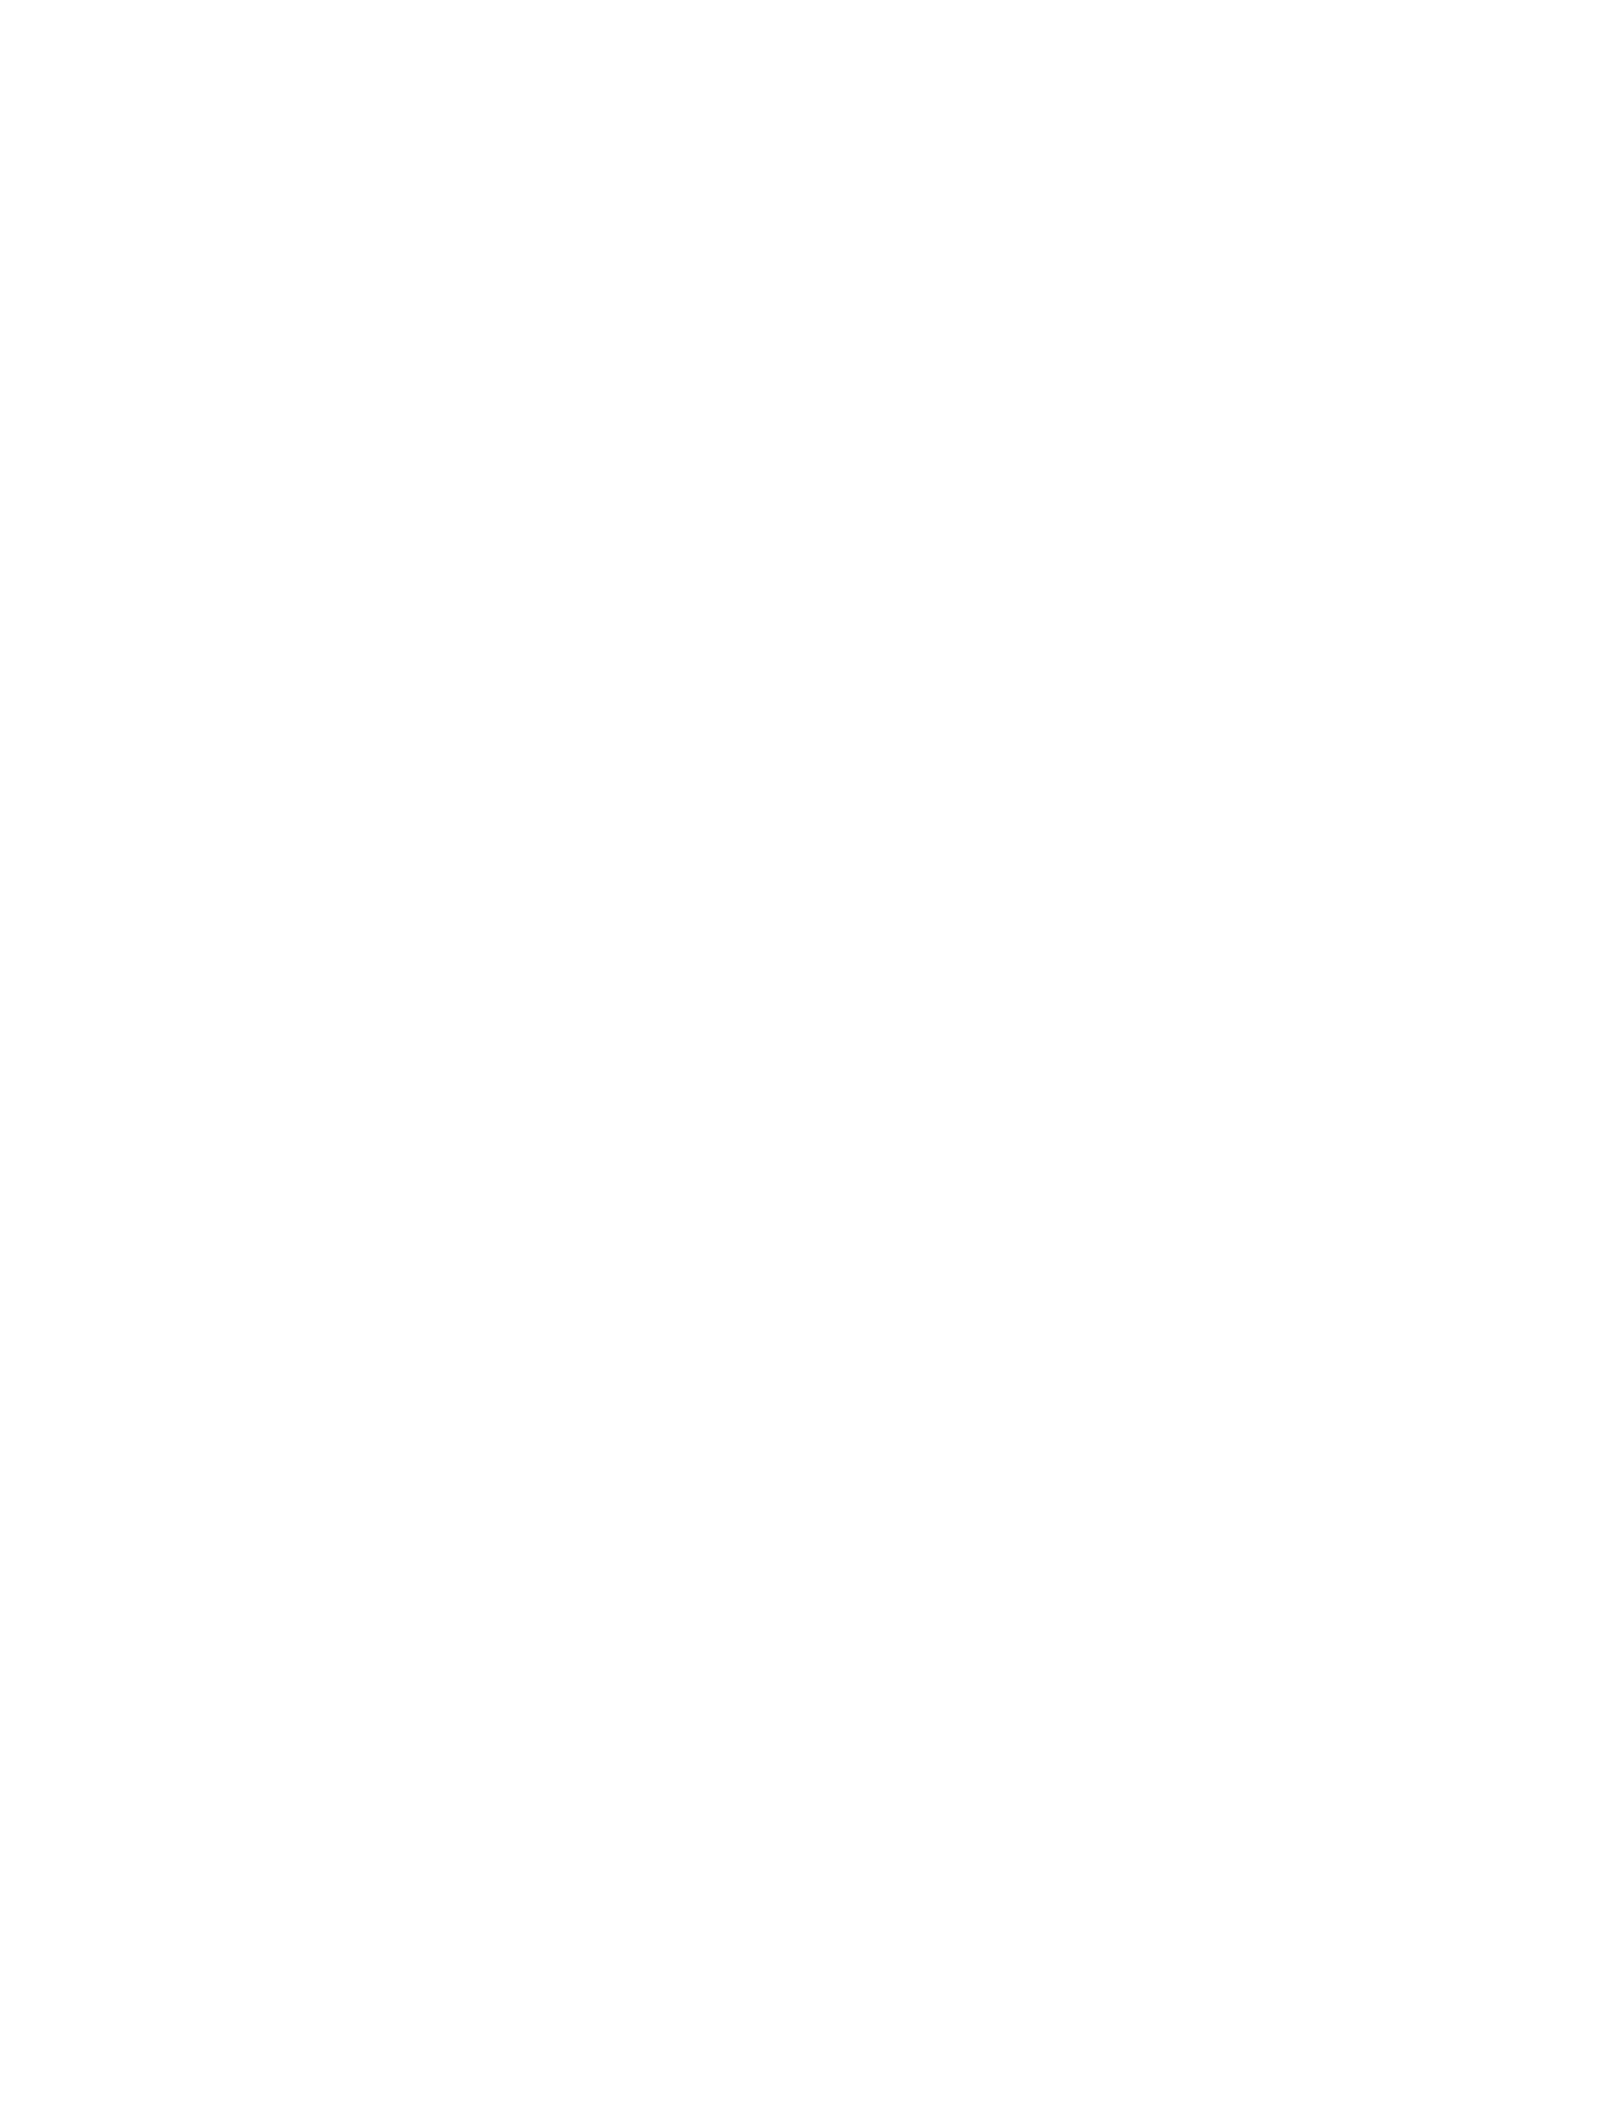

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.robust.robust_linear_model import RLM

def plot_and_calculate_log_reg(ds_in, distance_from_edge, freq, ax=None):
    # --- Your data ---
    x = distance_from_edge.values
    y = np.log(ds_in['EF'].sel(freq=freq).values)#  / ds_in['ICE'].values
    
    # Mask: finite values, x > 0, EF > 1e-11
    mask = np.isfinite(x) & np.isfinite(y) & (x > 0) & (ds_in['EF'].sel(freq=freq).values > 1e-12) & (ds_in['ICE'].values > 0.1)
    x = x[mask]
    y = y[mask]
    
    if len(x) < 2:  # not enough points to fit
        print("Not enough data")
        return None, None

    x = x - x.min()
    
    # --- Define log regression function ---
    def log_func(x, a, b):
        return a + b * np.log(x)
    


    # --- Prepare design matrix for simple regression ---
    X = x
    X = sm.add_constant(X)  # adds intercept term

    # --- Ordinary Least Squares regression ---
    model = sm.OLS(y, X).fit()
    beta0, beta1 = model.params
    alpha = -beta1  # same definition you used before

    # --- Predictions for plotting ---
    x_fit = x #np.linspace(x.min(), x.max(), 200)
    X_fit = sm.add_constant(x_fit)
    y_fit = model.predict(X_fit)

    # --- Plot ---
    if ax is not None:
        ax.scatter(x, y, label="Data", s=10)
        ax.plot(x_fit, y_fit, color="red", lw=1.5,
                label=f"y = {beta0:.2e} + {beta1:.2e} x")
        ax.set_title(f"Freq = {float(freq):.3f} Hz")
        ax.set_xlabel("Distance into ice [m]")
        ax.set_ylabel("log(E(f))$  [m$^2$ s]")
        ax.legend(fontsize=8)

    return beta0, alpha


# --- Loop over all freqs and create subplots ---
freqs = ds_wave_in_ice.freq.values
n_freqs = len(freqs)

ncols = 4  # choose how many per row
nrows = int(np.ceil(n_freqs / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), constrained_layout=True)
axes = axes.flatten()

alphas = []
intercepts = []

for i, freq in enumerate(freqs):
    intercept, alpha = plot_and_calculate_log_reg(
        ds_wave_in_ice,
        distance_into_ice,
        freq, 
        ax=axes[i]
    )
    if intercept is None:  # no valid data
        axes[i].axis("off")
    intercepts.append(intercept)
    alphas.append(alpha)

# Hide any unused subplot slots (after last frequency)
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.show()

In [33]:
ds_wave_in_ice['EF'].sel(freq=8).values
ds_wave_in_ice['ICE'].values

array([0.00013318, 0.        , 0.        ], dtype=float32)

In [34]:
alphas

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

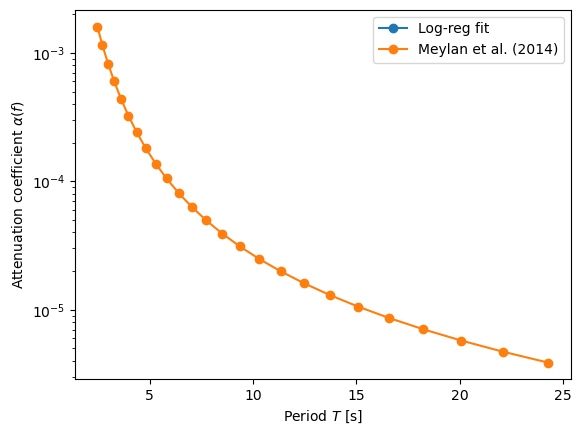

In [35]:
# Parameters from SPECTRUM_NML
f1 = 0.04118   # lowest frequency [Hz]
xfr = 1.1      # frequency growth factor
nk = 25        # number of frequency bins

# Compute frequency bins
freqs = f1 * xfr**np.arange(nk)
periods = 1.0 / freqs  # convert to periods

# --- Compute which frequencies have sufficient energy ---
energy_threshold = 1e-11
valid_mask = []

for ifreq, freq in enumerate(freqs):
    EF_vals = ds_wave_in_ice['EF'].sel(freq=ifreq).values
    if np.nanmax(EF_vals) > energy_threshold:
        valid_mask.append(True)
    else:
        valid_mask.append(False)

valid_mask = np.array(valid_mask)

# Apply mask to alphas and periods
periods_valid = periods[valid_mask]
alphas_valid = np.array(alphas)[valid_mask]

# --- Plot observed attenuation ---
plt.plot(periods_valid, alphas_valid, 'o-', label="Log-reg fit")

plt.xlabel('Period $T$ [s]')
plt.ylabel('Attenuation coefficient $\\alpha (f)$')

plt.plot(periods, alpha_MBK, 'o-', label="Meylan et al. (2014)")

plt.yscale('log')

plt.legend()
plt.show()

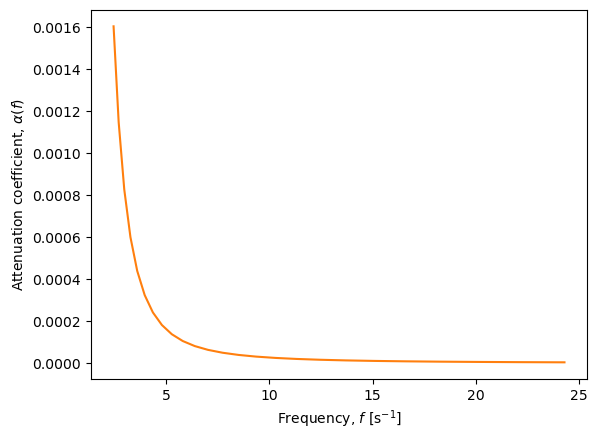

In [36]:


# Print nicely
# for i, (f, T) in enumerate(zip(freqs, periods), start=1):
    # print(f"Bin {i:2d}: {f:.5f} Hz  ({T:.2f} s)")

plt.plot(periods, alphas)
plt.xlabel('Frequency, $f$ [s$^{-1}$]')
plt.ylabel('Attenuation coefficient, $\\alpha (f)$')

# Meylan et al. (2014)

a = 2.2*10**-3
b = 4.59*10**-2
alpha_MBK = a/periods**2 + b/periods**4
alpha_MBK

plt.plot(periods, alpha_MBK)

In [37]:
# ds_tmp = xr.open_dataset('/scratch/ps29/nd0349/access-om3/work/wav_config_iaf_tune/access-om3.ww3.hi.1958-02-28-00000.nc')
# ds_tmp



In [38]:
plt.plot(periods, ds_wave_in_ice['EF'].isel(ny=-6))
plt.plot(periods, ds_wave_in_ice['EF'].isel(ny=-7), linestyle='--')
plt.plot(periods, ds_wave_in_ice['EF'].isel(ny=-8), linestyle=':')
plt.yscale('log')

IndexError: index -6 is out of bounds for axis 1 with size 3

In [ ]:
client.close()